In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt

In [18]:


zspec =[]
file_zspec = open(f'gpzpp/example/sdss_pred.cat','r')
#file_zspec['VALUE']
for _ in range(1):
    next(file_zspec)
for line in file_zspec:
    #print(len(line))
    splitter = re.sub("\s+",",",line.strip())
    tokens = splitter.split(',')
    zspec.append(float(tokens[10]))

        

In [136]:
print(np.linspace(100,500,9))

[100. 150. 200. 250. 300. 350. 400. 450. 500.]


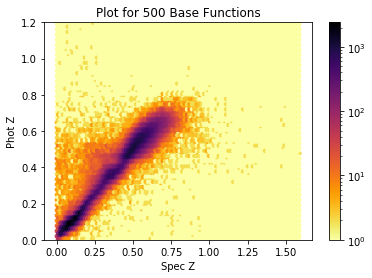

In [176]:




for nbf in [500]:#np.linspace(100,500,9, dtype=int):
    zphot = []
    error=[]
    file = open(f'MPhys/diag_sdss_catalogues/gpz_nbf{nbf}.cat','r')
    for _ in range(11):
        next(file)
    for line in file:
        splitter_numbf = re.sub("\s+",",",line.strip())
        tokens_numbf = splitter_numbf.split(',')
       #
        zphot.append(float(tokens_numbf[0]))
        error.append(float(tokens_numbf[1])/float(1+float(tokens[10])))
    data = np.array((zspec,zphot,error))

    plt.xlabel('Spec Z')
    plt.ylabel('Phot Z')
    #plt.errorbar(data[0],data[1], yerr = data[2], fmt = 'o', alpha = 0.08)
    plt.hexbin(data[0],data[1],gridsize= 100, cmap = 'inferno_r', alpha= 1, bins='log')

        
    plt.title('Plot for '+str(nbf)+' Base Functions')
    
    #plt.xlim(0.,1)
    plt.ylim(0,1.2)
    plt.savefig('MPhys/diag_sdss_catalogues/'+str(nbf)+'nbf_plot_scatter.png', bbox_inches='tight')
    plt.colorbar()
    
    #fig.tight_layout()
   
        #
    #plt.title('test')


-0.0013873


Text(0, 0.5, 'Phot Z')

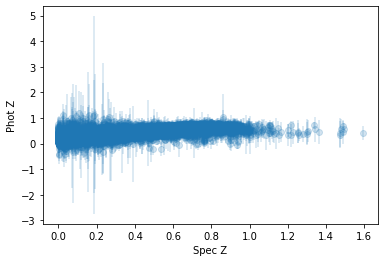

Text(0, 0.5, 'Phot Z')

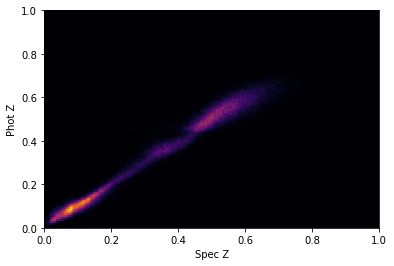

In [96]:
#used if using log scales
#goodx =[]
#goody=[]
#gooderr =[]
#for i in range(len(data[0])):
#    if data[0][i]>0:
#        if data[1][i]>0:
#            if data[2][i]>0:
#                goodx.append(data[0][i])
#                goody.append(data[1][i])
#                gooderr.append(data[2][i])
#data_good = np.array((goodx,goody, gooderr))
#print(np.max(data_good[0]),np.min(data_good[0]))

        
